# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

Keyring is skipped due to an exception: 'keyring.backends'

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import os
import sagemaker
import boto3
from sagemaker.pytorch import PyTorch


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [4]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
#!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
#!unzip dogImages.zip

In [5]:
session = sagemaker.Session()
bucket= session.default_bucket()
role = sagemaker.get_execution_role()
region = session.boto_region_name

In [6]:
os.environ["DEFAULT_S3_BUCKET"] = bucket
#!aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/dogImages

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [7]:
#TODO: Declare your HP ranges, metrics etc.
import sagemaker
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)



hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
    "epochs": IntegerParameter(2, 4)
}

objective_metric_name = "accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "accuracy", "Regex": "\((\d+)%\)"}]

In [8]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.xlarge"
)# TODO: Your estimator here

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=4,
    objective_type=objective_type,
)
# TODO: Your HP tuner here

In [11]:
# TODO: Fit your HP Tuner
train_images_path = f"s3://{bucket}/dogImages/train"
print(train_images_path)
validation_images_path = f"s3://{bucket}/dogImages/valid"
print(validation_images_path)

tuner.fit({"train": train_images_path, "test": validation_images_path}) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


s3://sagemaker-us-east-1-820131057864/dogImages/train
s3://sagemaker-us-east-1-820131057864/dogImages/valid
...................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [12]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()#TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-02-14 08:27:32 Starting - Preparing the instances for training
2023-02-14 08:27:32 Downloading - Downloading input data
2023-02-14 08:27:32 Training - Training image download completed. Training in progress.
2023-02-14 08:27:32 Uploading - Uploading generated training model
2023-02-14 08:27:32 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"accuracy"',
 'batch-size': '"256"',
 'epochs': '4',
 'lr': '0.002564503867458704',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-02-14-07-57-50-222"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-820131057864/pytorch-training-2023-02-14-07-57-50-222/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [13]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

rules = [
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
]

from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "10", "eval.save_interval": "1"}
)

In [15]:
hyperparameters = {
    "batch-size": "256",
 "epochs": 4,
 "lr": "0.002564503867458704",
}

In [17]:
# TODO: Create and fit an estimator

from sagemaker.pytorch import PyTorch


estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    source_dir=".",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

estimator.fit({"train": train_images_path, "test": validation_images_path}, wait=True)


2023-02-14 08:56:32 Starting - Starting the training job...
2023-02-14 08:56:59 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-02-14 08:57:59 Downloading - Downloading input data......
2023-02-14 08:58:59 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-02-14 08:58:58,105 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-02-14 08:58:58,107 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-02-14 08:58:58,115 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-02-14 08:58:58,117 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-02-14 08:59:15,404 sagemaker-training-toolkit INFO     

In [22]:
training_job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")


Training jobname: pytorch-training-2023-02-14-08-54-36-852
Region: us-east-1


In [27]:
import time
from IPython import display

%matplotlib inline

while description["SecondaryStatus"] not in {"Stopped", "Completed"}:
    description = client.describe_training_job(TrainingJobName=job_name)
    primary_status = description["TrainingJobStatus"]
    secondary_status = description["SecondaryStatus"]
    print("====================================================================")
    print("TrainingJobStatus: ", primary_status, " | SecondaryStatus: ", secondary_status)
    print("====================================================================")
    for r in range(len(estimator.latest_training_job.rule_job_summary())):
        rule_summary = estimator.latest_training_job.rule_job_summary()
        print(
            rule_summary[r]["RuleConfigurationName"], ": ", rule_summary[r]["RuleEvaluationStatus"]
        )
        if rule_summary[r]["RuleEvaluationStatus"] == "IssuesFound":
            print(rule_summary[r]["StatusDetails"])
        print("====================================================================")
    print("Current time: ", time.asctime())
    display.clear_output(wait=True)
    time.sleep(100)

In [26]:
def _get_rule_job_name(training_job_name, rule_configuration_name, rule_job_arn):
    """Helper function to get the rule job name with correct casing"""
    return "{}-{}-{}".format(
        training_job_name[:26], rule_configuration_name[:26], rule_job_arn[-8:]
    )


def _get_cw_url_for_rule_job(rule_job_name, region):
    return "https://{}.console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix".format(
        region, region, rule_job_name
    )


def get_rule_jobs_cw_urls(estimator):
    region = boto3.Session().region_name
    training_job = estimator.latest_training_job
    training_job_name = training_job.describe()["TrainingJobName"]
    rule_eval_statuses = training_job.describe()["DebugRuleEvaluationStatuses"]

    result = {}
    for status in rule_eval_statuses:
        if status.get("RuleEvaluationJobArn", None) is not None:
            rule_job_name = _get_rule_job_name(
                training_job_name, status["RuleConfigurationName"], status["RuleEvaluationJobArn"]
            )
            result[status["RuleConfigurationName"]] = _get_cw_url_for_rule_job(
                rule_job_name, region
            )
    return result


get_rule_jobs_cw_urls(estimator)

{'VanishingGradient': 'https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logStream:group=/aws/sagemaker/ProcessingJobs;prefix=pytorch-training-2023-02-1-VanishingGradient-e90b38bc;streamFilter=typeLogStreamPrefix',
 'Overfit': 'https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logStream:group=/aws/sagemaker/ProcessingJobs;prefix=pytorch-training-2023-02-1-Overfit-9a21fc95;streamFilter=typeLogStreamPrefix'}

In [28]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())


[2023-02-14 11:15:04.165 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:125 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-02-14 11:15:04.176 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:125 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-820131057864/pytorch-training-2023-02-14-08-54-36-852/debug-output


In [29]:
trial.tensor_names()


[2023-02-14 11:15:34.996 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:125 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-02-14 11:15:36.015 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:125 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight']

In [30]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))


11

In [31]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))


16

In [33]:
# TODO: Plot a debugging output.
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = host.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


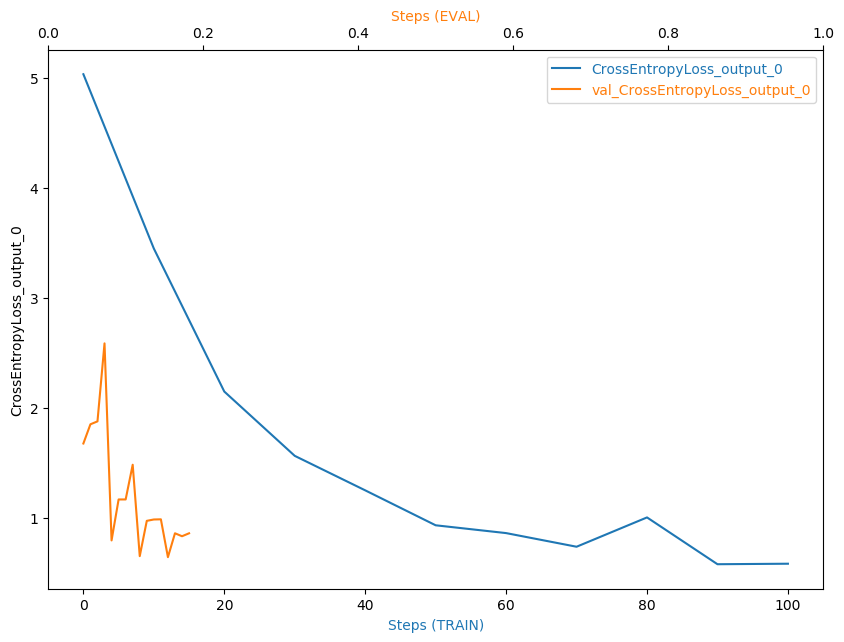

In [35]:
plot_tensor(trial, "CrossEntropyLoss_output_0")


In [48]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-820131057864/pytorch-training-2023-02-14-08-54-36-852/rule-output


In [49]:
! aws s3 ls {rule_output_path} --recursive


2023-02-14 09:18:28     375774 pytorch-training-2023-02-14-08-54-36-852/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-02-14 09:18:28     223707 pytorch-training-2023-02-14-08-54-36-852/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-02-14 09:18:23        192 pytorch-training-2023-02-14-08-54-36-852/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-02-14 09:18:23        200 pytorch-training-2023-02-14-08-54-36-852/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-02-14 09:18:23       2152 pytorch-training-2023-02-14-08-54-36-852/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-02-14 09:18:23        127 pytorch-training-2023-02-14-08-54-36-852/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-02-14 09:18:23        199 pytorch-training-2023-02-14-08-54-36-852/rule-output/ProfilerReport/profiler-output/profiler-re

In [53]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-820131057864/pytorch-training-2023-02-14-08-54-36-852/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-820131057864/pytorch-training-2023-02-14-08-54-36-852/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker-us-east-1-820131057864/pytorch-training-2023-02-14-08-54-36-852/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-820131057864/pytorch-training-2023-02-14-08-54-36-852/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-8201310

In [57]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [63]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [59]:
from sagemaker.pytorch import PyTorchModel

pytorch_model = PyTorchModel(model_data=estimator.model_data, 
                             role=role, 
                             entry_point='deply.py', 
                             py_version='py36',
                             framework_version='1.8')


predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')


-----!

In [60]:
from sagemaker.serializers import IdentitySerializer
predictor.serializer = IdentitySerializer("image/jpeg")

In [62]:
# TODO: Run an prediction on the endpoint
from PIL import Image
from IPython.display import Image as ImageDisplay
import io

def predict_dog(image_path):    
    buf = io.BytesIO()
    Image.open(image_path).save(buf, format="JPEG")
    response = predictor.predict(buf.getvalue())
    
    folders = list(listdir("./dogImages/train"))
    folders.sort()
    return folders[list(response[0]).index(max(response[0]))]
    

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()